## Stata in a jupyter notebook

The jupyter notebook project is now designed to be a 'language agnostic' web-application front-end for any one of many possible software language kernels.  We've been mostly using python but there are in fact several dozen [other language kernels](https://github.com/ipython/ipython/wiki/IPython-kernels-for-other-languages) that can be made to work with it. 

The ecosystem of libraries and packages for scientific computing with python is huge and constantly growing but there are still many statistics and econometrics applications that are available as built-in or user-written modules in Stata that have not yet been ported to python or are just simply easier to use in Stata.  On the other hand there are some libraries such as python  pandas and different visualization libraries such as seaborn or matplotlib that give features that are not available in Stata. 

Fortunately you don't have to choose between using Stata or python, you can use them both together, to get the best of both worlds.    

There are at least two ways to run Stata in a jupyter notebook by itself or together with python. Both methods naturally require that you also have Stata installed on your machine to run and that you setup something called [Stata automation](http://www.stata.com/automation/#createmsapp) which seems to be possible only on Windows machines.  Both are relatively easy to setup.

- *[Method 1: stata-kernel](https://github.com/jrfiedler/stata-kernel):* James Fiedler has written a kernel for Stata which allows you to create and run standalone interactive Stata notebook sessions. Inline plots do not seem possible.  

- *[Method 2: ipystata](https://github.com/TiesdeKok/ipystata):* Ties de Kok has written a nice python library that allows one to write and execute Stata code in cellblocks that are preceded by a ```%%stata``` magic command in a notebook that is otherwise running python. This allows you to pass data between python and Stata sessions and to display Stata plots inline. 

### A sample ipystata session

Below is a simple example of this second method in use.  For more details see the [example notebook](http://nbviewer.jupyter.org/github/TiesdeKok/ipystata/blob/master/ipystata/Example.ipynb) and documentation on the ipystata repository.

In [6]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import ipystata

The following opens a Stata session where we load a dataset and summarize the data.  The ```-o``` flag following the `%%Stata``` magic instructs it to output or return the dataset in Stata memory as a pandas dataframe in python. 

In [3]:
%%stata -o life_df
sysuse lifeexp.dta
summarize


(Life expectancy, 1998)

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
      region |         68         1.5    .7431277          1          3
     country |          0
   popgrowth |         68    .9720588    .9311918        -.5          3
        lexp |         68    72.27941    4.715315         54         79
       gnppc |         63    8674.857    10634.68        370      39980
-------------+---------------------------------------------------------
   safewater |         40        76.1    17.89112         28        100



Let's confirm the data was returned as a pandas dataframe:

In [4]:
life_df.head(3)

,region,country,popgrowth,lexp,gnppc,safewater
0,Eur & C.Asia,Albania,1.2,72,810.0,76.0
1,Eur & C.Asia,Armenia,1.1,74,460.0,NaN
2,Eur & C.Asia,Austria,0.4,79,26830.0,NaN


A simple  generate variable command and ols regression in Stata:

In [5]:
%%stata -o life_df
gen lngnppc = ln(gnppc)
regress lexp lngnppc

(5 missing values generated)

      Source |       SS           df       MS      Number of obs   =        63
-------------+----------------------------------   F(1, 61)        =     97.09
       Model |  873.264865         1  873.264865   Prob > F        =    0.0000
    Residual |  548.671643        61  8.99461709   R-squared       =    0.6141
-------------+----------------------------------   Adj R-squared   =    0.6078
       Total |  1421.93651        62  22.9344598   Root MSE        =    2.9991

------------------------------------------------------------------------------
        lexp |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     lngnppc |   2.768349   .2809566     9.85   0.000     2.206542    3.330157
       _cons |   49.41502   2.348494    21.04   0.000     44.71892    54.11113
------------------------------------------------------------------------------



And the same regression using statsmodels and pandas:

In [8]:
model = smf.ols(formula = 'lexp ~ lngnppc',
                data = life_df)
results = model.fit()

In [9]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   lexp   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     97.09
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           3.13e-14
Time:                        11:33:50   Log-Likelihood:                -157.57
No. Observations:                  63   AIC:                             319.1
Df Residuals:                      61   BIC:                             323.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.4150      2.348     21.041      0.0

Let's change one of the variables in the dataframe in python:

In [10]:
life_df.popgrowth = life_df.popgrowth * 100

In [11]:
life_df.popgrowth.mean()

97.20587921142578

And now let's push the modified dataframe into the Stata dataset with the ```-d``` flag:

In [12]:
%%stata -d life_df
summarize


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
       index |         68        33.5    19.77372          0         67
      region |         68          .5    .7431277          0          2
     country |          0
   popgrowth |         68    97.20588    93.11918        -50        300
        lexp |         68    72.27941    4.715315         54         79
-------------+---------------------------------------------------------
       gnppc |         63    8674.857    10634.68        370      39980
   safewater |         40        76.1    17.89112         28        100
     lngnppc |         63    8.250023    1.355677   5.913503   10.59613



A Stata plot:

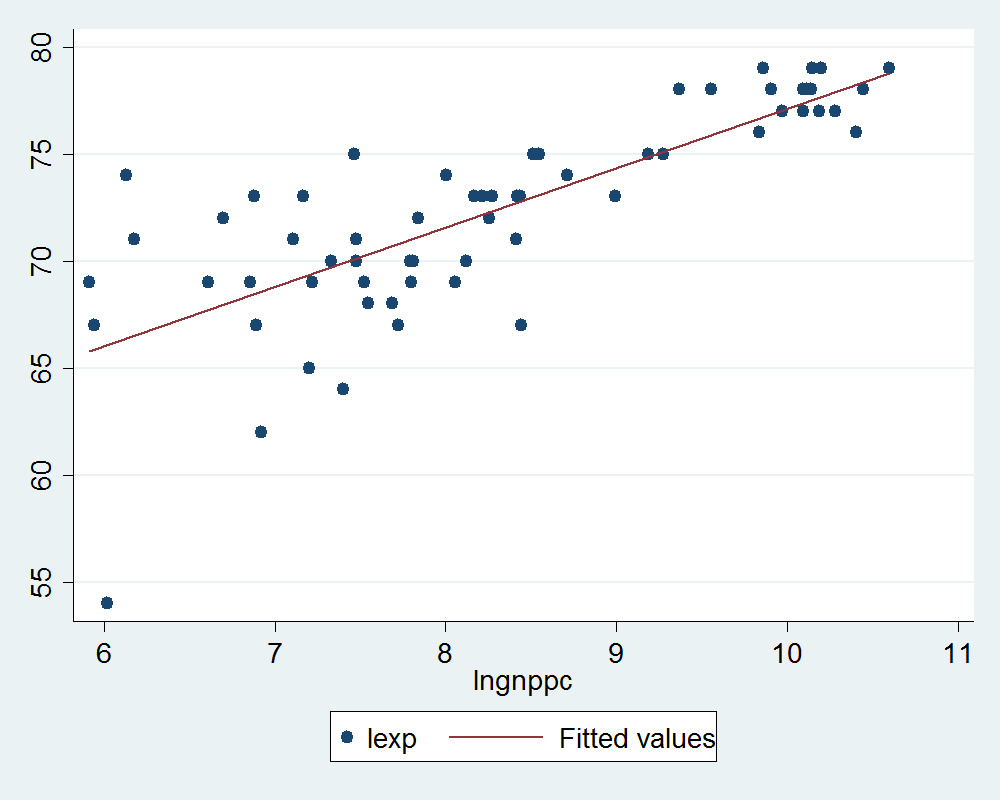

In [13]:
%%stata -d life_df --graph 
graph twoway (scatter lexp lngnppc) (lfit lexp lngnppc)

Now on the python side use lmplot from the seaborn library to graph a similar scatter and fitted line but by region.

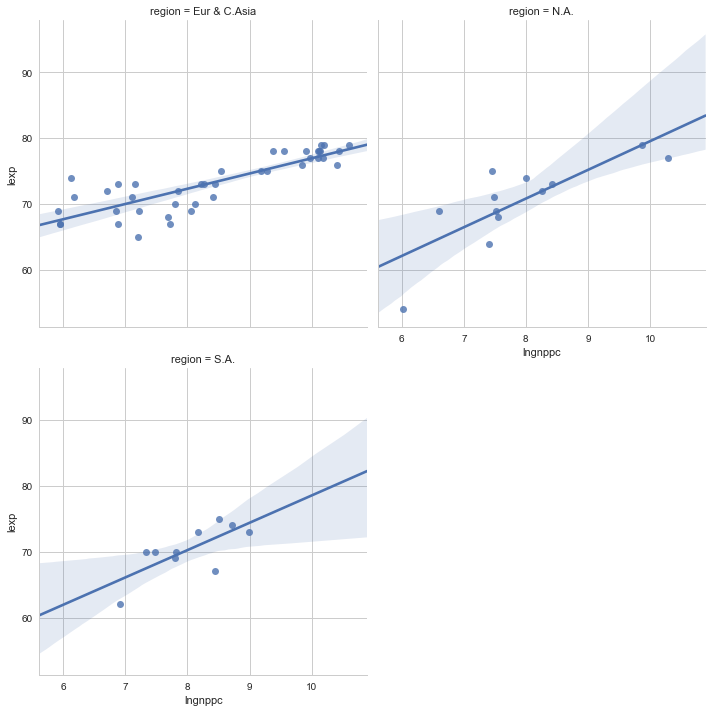

In [14]:
sns.set_style("whitegrid")
g=sns.lmplot(y='lexp', x='lngnppc', col='region', data=life_df,col_wrap=2)